In [59]:
import os
import shutil
import random
from PIL import Image
import torch
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from torchvision import models, transforms
from torchvision.utils import save_image
import numpy as np
import hdbscan
import matplotlib.gridspec as gridspec
from sklearn.model_selection import GridSearchCV

In [60]:
# Define main directories
folders = {
    "data_full": ["preprocessed_images", "raw"],
    "data_sample": ["preprocessed_images", "raw"]
}

# Create directories if they don't exist
for main_folder, subfolders in folders.items():
    os.makedirs(main_folder, exist_ok=True)
    for subfolder in subfolders:
        os.makedirs(os.path.join(main_folder, subfolder), exist_ok=True)

In [61]:
# If data not stored locally run this cell to fetch it
"""
# Define paths
download_dir = os.path.join("data_full", "raw")
os.makedirs(download_dir, exist_ok=True)

# Download dataset
path = kagglehub.dataset_download("steubk/wikiart", path=download_dir)

def flatten_directory(directory):
    # Move all files from subdirectories to parent directory and delete subdirs
    for root, dirs, files in os.walk(directory, topdown=False):
        # Skip the parent directory itself
        if root == directory:
            continue
            
        for file in files:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(directory, file)
            
            # Handle potential filename conflicts
            if os.path.exists(dest_path):
                base, extension = os.path.splitext(file)
                counter = 1
                # Generate unique filename by appending _n
                while os.path.exists(dest_path):
                    new_name = f"{base}_{counter}{extension}"
                    dest_path = os.path.join(directory, new_name)
                    counter += 1
                    
            shutil.move(src_path, dest_path)
        
        # Remove the emptied directory
        shutil.rmtree(root)

# Flatten the directory structure
flatten_directory(download_dir)
print(f"All files consolidated in: {download_dir}")

"""

'\n# Define paths\ndownload_dir = os.path.join("data_full", "raw")\nos.makedirs(download_dir, exist_ok=True)\n\n# Download dataset\npath = kagglehub.dataset_download("steubk/wikiart", path=download_dir)\n\ndef flatten_directory(directory):\n    # Move all files from subdirectories to parent directory and delete subdirs\n    for root, dirs, files in os.walk(directory, topdown=False):\n        # Skip the parent directory itself\n        if root == directory:\n            continue\n            \n        for file in files:\n            src_path = os.path.join(root, file)\n            dest_path = os.path.join(directory, file)\n            \n            # Handle potential filename conflicts\n            if os.path.exists(dest_path):\n                base, extension = os.path.splitext(file)\n                counter = 1\n                # Generate unique filename by appending _n\n                while os.path.exists(dest_path):\n                    new_name = f"{base}_{counter}{extension}"\n  

In [62]:
# if sample data is needed run this cell

def ensure_flat_directory(directory):
    # Check for subdirectories and flatten if needed
    # Check if any subdirectories exist
    has_subdirs = any(os.path.isdir(os.path.join(directory, item)) 
                    for item in os.listdir(directory))
    
    if has_subdirs:
        print("Subdirectories detected - flattening structure...")
        flatten_directory(directory)
    else:
        print("No subdirectories detected - structure already flat")

def flatten_directory(directory):
    # Flatten directory structure by moving all files to root
    for root, dirs, files in os.walk(directory, topdown=False):
        # Skip the root directory itself
        if root == directory:
            continue
            
        for file in files:
            src = os.path.join(root, file)
            dst = os.path.join(directory, file)
            
            # Handle duplicates
            if os.path.exists(dst):
                base, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(dst):
                    new_name = f"{base}_{counter}{ext}"
                    dst = os.path.join(directory, new_name)
                    counter += 1
                    
            shutil.move(src, dst)
        
        # Remove emptied directory
        if os.path.exists(root):
            shutil.rmtree(root)

def create_sample_dataset(source_dir, dest_dir, n=500):
    # Create sample dataset with n random files
    # Get all files after flattening
    all_files = [f for f in os.listdir(source_dir) 
                 if os.path.isfile(os.path.join(source_dir, f))]
    
    # Adjust sample size
    sample_size = min(n, len(all_files))
    if sample_size < n:
        print(f"Warning: Only {len(all_files)} files available")
    
    # Create destination
    os.makedirs(dest_dir, exist_ok=True)
    
    # Copy random sample
    for file in random.sample(all_files, sample_size):
        src = os.path.join(source_dir, file)
        dst = os.path.join(dest_dir, file)
        shutil.copy2(src, dst)

def handle_existing_files(directory):
    preprocessed_dir = os.path.join("data_sample", "preprocessed_images")
    if os.path.exists(directory) and os.listdir(directory):
        choice = input(f"Files already exist in {directory}. Do you want to (S)kip or (D)elete and create new? ").strip().lower()
        if choice == 'd':
            shutil.rmtree(directory)
            os.makedirs(directory, exist_ok=True)
            print("Existing files in raw deleted. Creating new sample dataset...")
            if os.path.exists(preprocessed_dir):
                shutil.rmtree(preprocessed_dir)
                os.makedirs(preprocessed_dir, exist_ok=True)
                print("Existing files in preprocessed_images deleted.")
        elif choice == 's':
            print("Skipping sample dataset creation.")
            return False
    return True

# Main execution flow
if __name__ == "__main__":
    # Setup paths
    raw_dir = os.path.join("data_full", "raw")
    sample_dir = os.path.join("data_sample", "raw")
    
    # Ensure flat structure
    ensure_flat_directory(raw_dir)
    
    # Create sample dataset
    if handle_existing_files(sample_dir):
        create_sample_dataset(raw_dir, sample_dir)
        print(f"Sample dataset created with files from {raw_dir} to {sample_dir}")

No subdirectories detected - structure already flat
Existing files in raw deleted. Creating new sample dataset...
Existing files in preprocessed_images deleted.
Sample dataset created with files from data_full\raw to data_sample\raw


In [63]:
# Define paths
input_dir = r"data_sample\raw"
output_dir = r"data_sample\preprocessed_images"

os.makedirs(output_dir, exist_ok=True)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

for root, _, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = preprocess(img)
                output_path = os.path.join(output_dir, file)
                save_image(img_tensor, output_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")




In [64]:
# List all files in the directory
files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]

# Filter for image files
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

if image_files:
    random_image = random.choice(image_files)
    test_img = Image.open(os.path.join(output_dir, random_image))
    print(f"Randomly selected image: {random_image}")
    test_tensor = transforms.ToTensor()(test_img)
    print("Tensor shape:", test_tensor.shape)
    print("Min/Max pixel value:", test_tensor.min(), test_tensor.max())
else:
    print("No images found.")

print("Tensor shape:", test_tensor.shape)  # Should be (3, 224, 224)
# print("Min/Max pixel value:", test_tensor.min(), test_tensor.max())  # Should be ~[0, 1] or [-2.1, 2.5] for ImageNet

Randomly selected image: vincent-van-gogh_rocks-with-oak-tree-1888.jpg
Tensor shape: torch.Size([3, 224, 224])
Min/Max pixel value: tensor(0.0784) tensor(0.9843)
Tensor shape: torch.Size([3, 224, 224])


In [65]:
# Convert images to embeddings.

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

# Correct transform without Resize/Crop
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Reload image files from output directory
output_dir = r"data_sample\preprocessed_images"
files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Extract embeddings
embeddings = []
for file in image_files:
    img_path = os.path.join(output_dir, file)
    try:
        image = Image.open(img_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)
        with torch.no_grad():
            embedding = model(image_tensor)
        embedding = embedding.squeeze().cpu().numpy()
        embeddings.append(embedding)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (500, 2048)


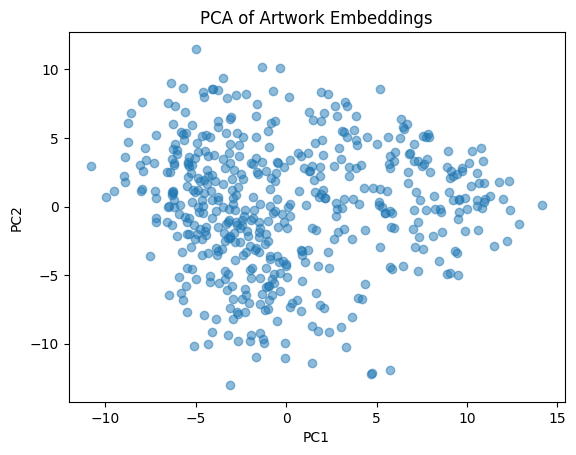

In [66]:
# EDA

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title("PCA of Artwork Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


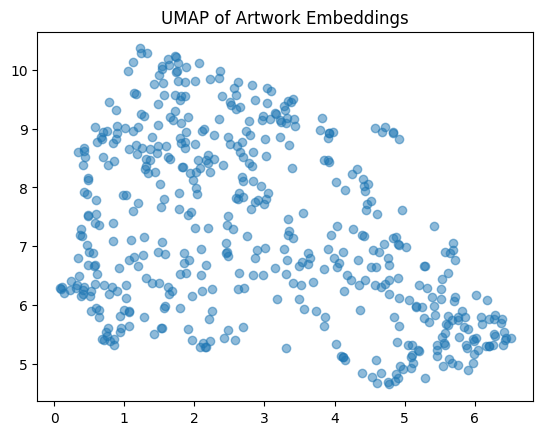

In [67]:
# Dimensionality Reduction

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], alpha=0.5)
plt.title("UMAP of Artwork Embeddings")
plt.show()

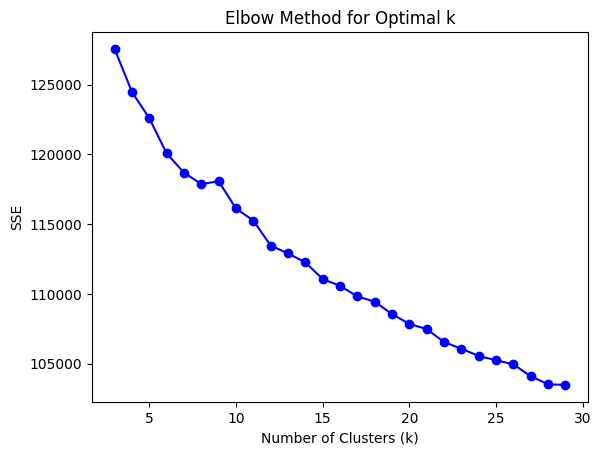

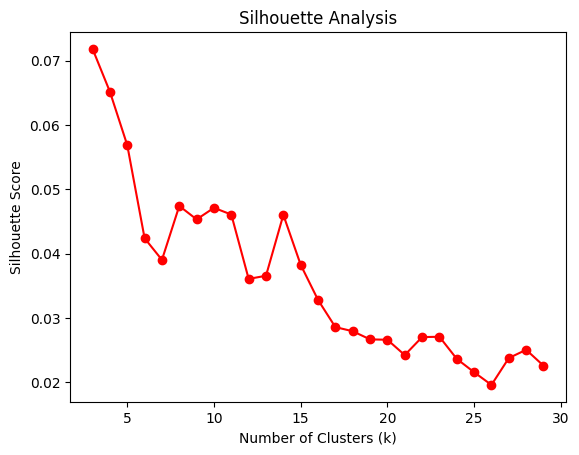

In [68]:
k_values = range(3, 30)
sse = []  # Sum of squared errors
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(embeddings)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, labels))

# Plot Elbow Curve
plt.plot(k_values, sse, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()

# Plot Silhouette Scores
plt.plot(k_values, silhouette_scores, 'ro-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

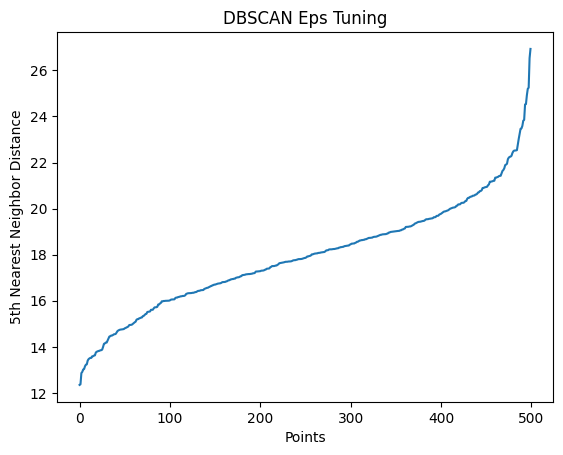

Unique clusters: [-1]


In [69]:
# Tune eps using nearest neighbors distance plot

nn = NearestNeighbors(n_neighbors=5).fit(embeddings)
distances, _ = nn.kneighbors(embeddings)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("DBSCAN Eps Tuning")
plt.show()

# Choose eps from the "knee" in the plot (e.g., 5)
dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(embeddings)
print(f"Unique clusters: {np.unique(dbscan_labels)}")

In [70]:
hdb = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
hdb_labels = hdb.fit_predict(embeddings)
print(f"Unique clusters: {np.unique(hdb_labels)}")

c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Unique clusters: [-1]


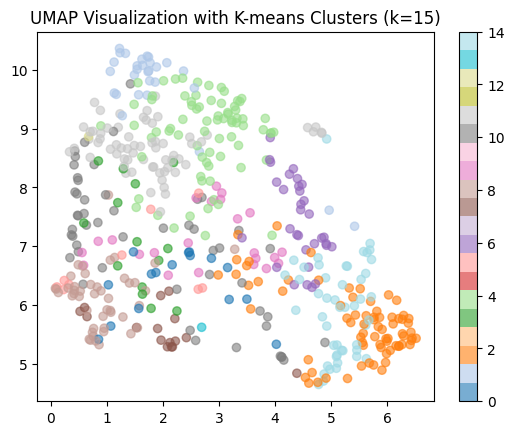

In [71]:
# For K-means (assuming optimal k=15)
kmeans = KMeans(n_clusters=15, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(embeddings)

plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
            c=kmeans_labels, cmap='tab20', alpha=0.6)
plt.title("UMAP Visualization with K-means Clusters (k=15)")
plt.colorbar()
plt.show()

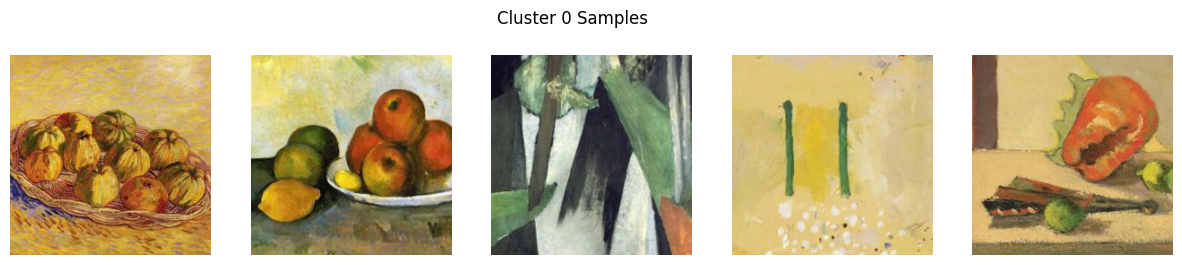

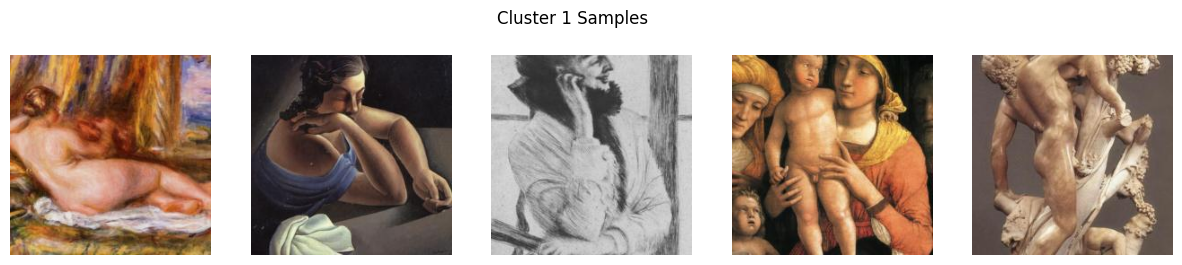

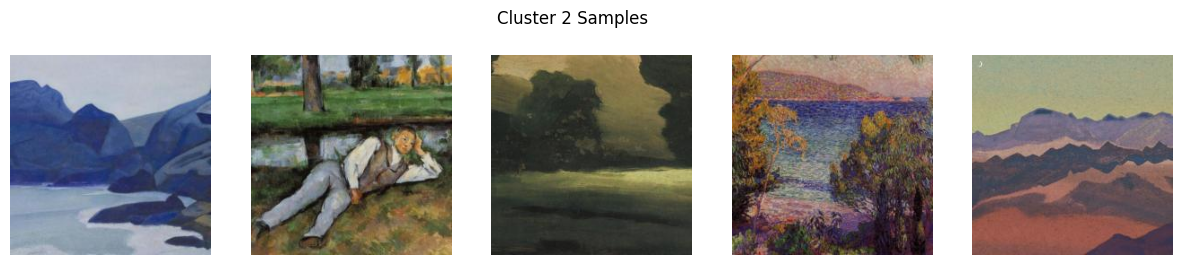

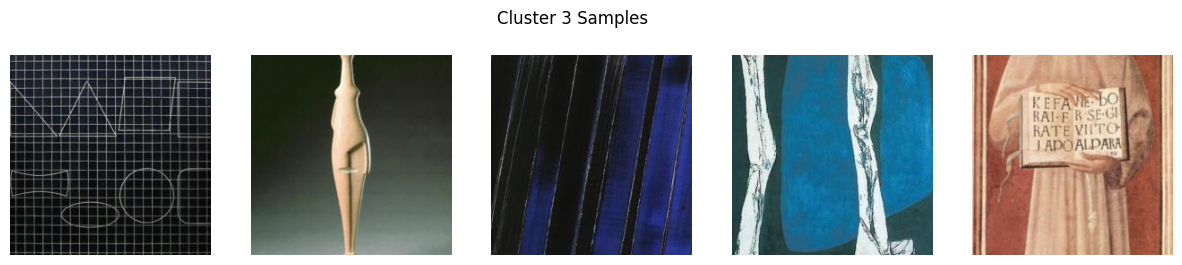

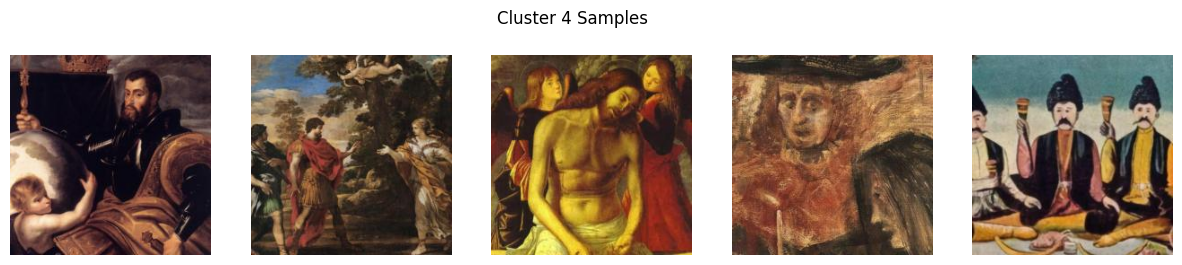

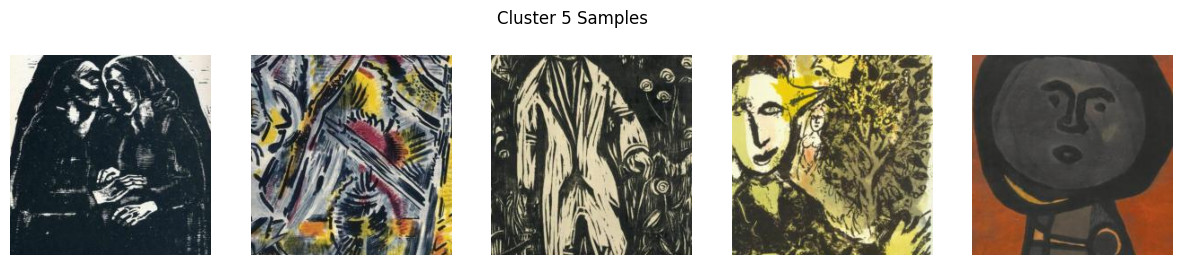

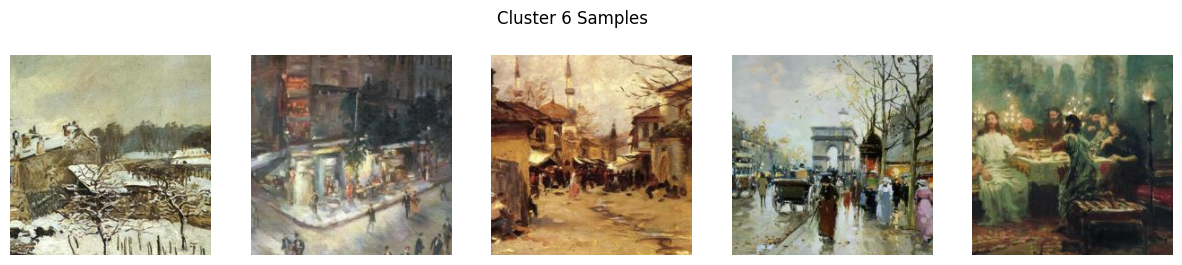

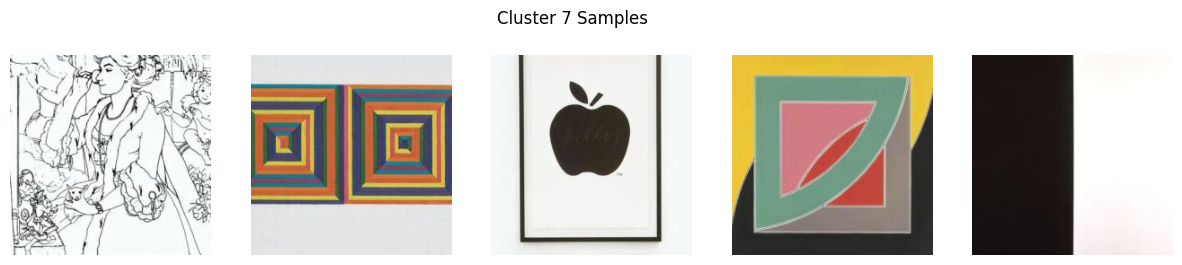

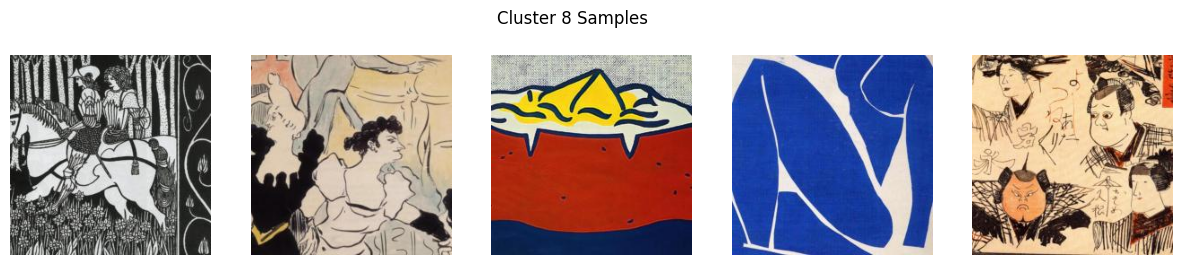

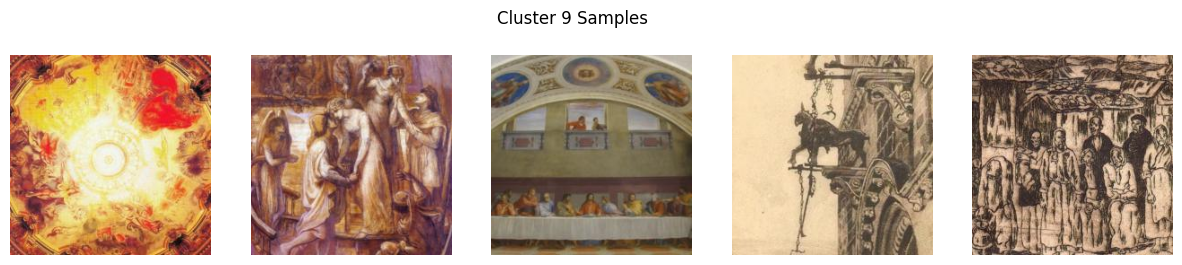

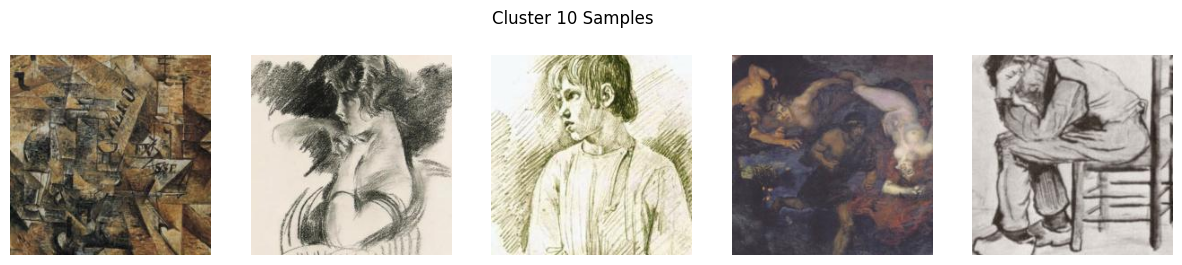

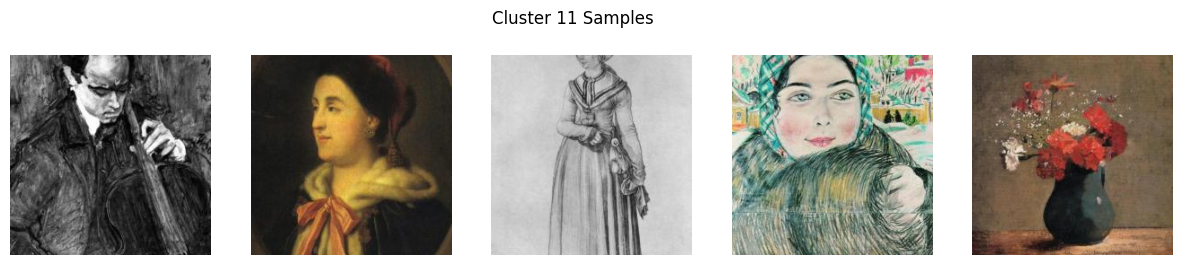

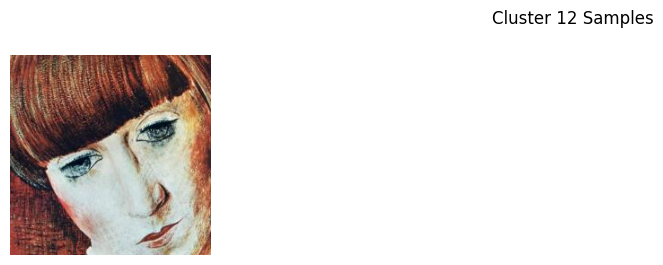

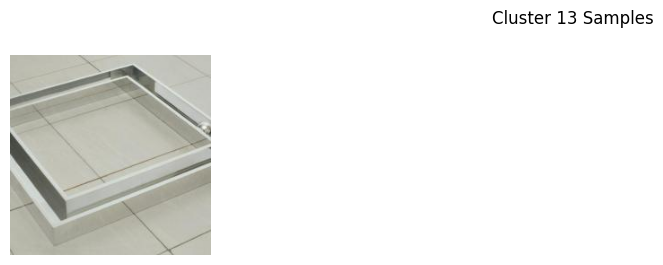

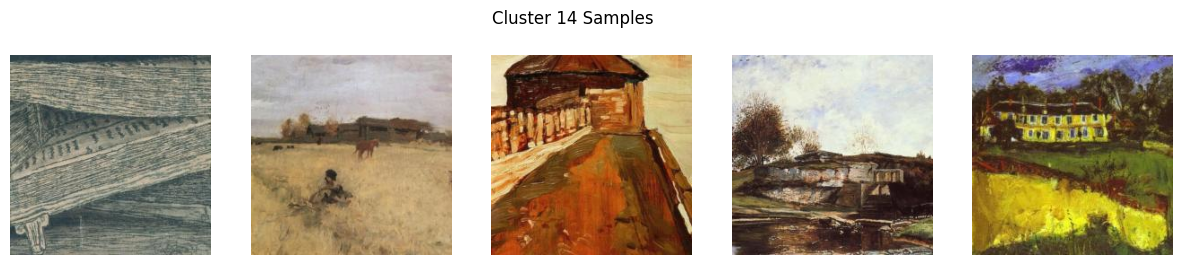

In [72]:
def plot_cluster_samples(labels, n_samples=5):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        if len(cluster_indices) == 0:
            continue
        samples = np.random.choice(cluster_indices, min(n_samples, len(cluster_indices)), replace=False)
        
        plt.figure(figsize=(15, 3))
        gs = gridspec.GridSpec(1, n_samples)
        for i, idx in enumerate(samples):
            ax = plt.subplot(gs[i])
            img = Image.open(os.path.join(output_dir, image_files[idx]))
            ax.imshow(img)
            ax.axis('off')
        plt.suptitle(f"Cluster {label} Samples")
        plt.show()

plot_cluster_samples(kmeans_labels)

In [73]:
# Compare models using Silhouette Score (if no ground truth)
print("K-means Silhouette:", silhouette_score(embeddings, kmeans_labels))
print("HDBSCAN Silhouette:", silhouette_score(embeddings, hdb_labels))

K-means Silhouette: 0.0382452


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)